In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
models = torch.load("model/gradvsODEvsFD_full.pt")

for model in models:
    model.eval()
None

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print("{} have {} parameters".format(type(model), count_parameters(model)))

<class 'torchdyn.core.neuralde.NeuralODE'> have 1219 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1219 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1220 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1218 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1219 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1219 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1220 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1218 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1219 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1219 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1220 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 1218 parameters


In [4]:
test_set = torch.load('data/SHM_test_set.pt')
training_set = torch.load('data/SHM_training_set_full.pt')[:4, :, :]

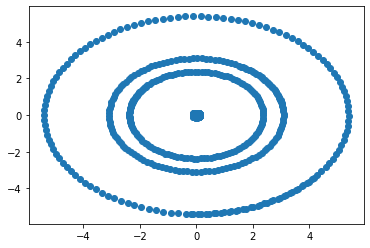

In [18]:
plt.scatter(training_set[:, :, 0], training_set[:, :, 1])

In [5]:
print(test_set.shape)
print(training_set.shape)

torch.Size([100, 500, 6])
torch.Size([4, 145, 6])


### Get test err

In [6]:
test_err = []
train_err = []
t_span1 = test_set[0, :, -1]
t_span2 = training_set[0, :, -1]

for model in models:
    est_traj = model.trajectory(test_set[:, 0, 0:2], t_span1).transpose(0,1)
    loss_test = torch.nn.functional.mse_loss(est_traj, test_set[:, :, 0:2]).detach()
    
    est_traj2 = model.trajectory(training_set[:, 0, 0:2], t_span2).transpose(0,1)
    loss_train = torch.nn.functional.mse_loss(est_traj2, training_set[:, :, 0:2]).detach()
    
    test_err.append(loss_test)
    train_err.append(loss_train)

In [7]:
model_name = ['hamODE', 'lagODE', 'symODE', 'baselineODE',
              'hamODE_grad', 'lagODE_grad', 'symODE_grad', 'baselineODE_grad',
              'hamODE_fd', 'lagODE_fd', 'symODE_fd', 'baselineODE_fd']

for i in range(len(test_err)):
    print(i, model_name[i], test_err[i], train_err[i])

0 hamODE tensor(22.2096) tensor(0.6900)
1 lagODE tensor(2.0076e+10) tensor(2.5399)
2 symODE tensor(21.3515) tensor(0.3231)
3 baselineODE tensor(0.9336) tensor(0.0120)
4 hamODE_grad tensor(21.8041) tensor(0.6022)
5 lagODE_grad tensor(2.7104e+10) tensor(2.4285)
6 symODE_grad tensor(20.9436) tensor(0.3057)
7 baselineODE_grad tensor(0.7587) tensor(0.0104)
8 hamODE_fd tensor(27.8568) tensor(10.1238)
9 lagODE_fd tensor(1.8902e+10) tensor(2.4228)
10 symODE_fd tensor(20.9911) tensor(0.3089)
11 baselineODE_fd tensor(0.5370) tensor(0.0183)


Epoch till converge: 8949 8236 3775 7848 8841 7422 3742 7968 102 7134 1076 8044

wall time: 388 681 785 189 87 96 77 69 1.12 91 21 70

### Trajectory Test

In [8]:
from utils import SHM_1D_model

In [9]:
# Generate Trajectory from true model
t0 = 0
dt = 0.05
steps = 200
t1 = int(dt * steps)

q_p1, dq_dp, _, ts = SHM_1D_model(x0=1.5, p0=1.5, t0=t0, t1=t1, steps=steps)
q_p2, dq_dp, _, ts = SHM_1D_model(x0=4, p0=4, t0=t0, t1=t1, steps=steps)


# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)
trajs1 = []
trajs2 = []

for model in models:
    traj1 = model.trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
    traj2 = model.trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
    
    trajs1.append(traj1)
    trajs2.append(traj2)

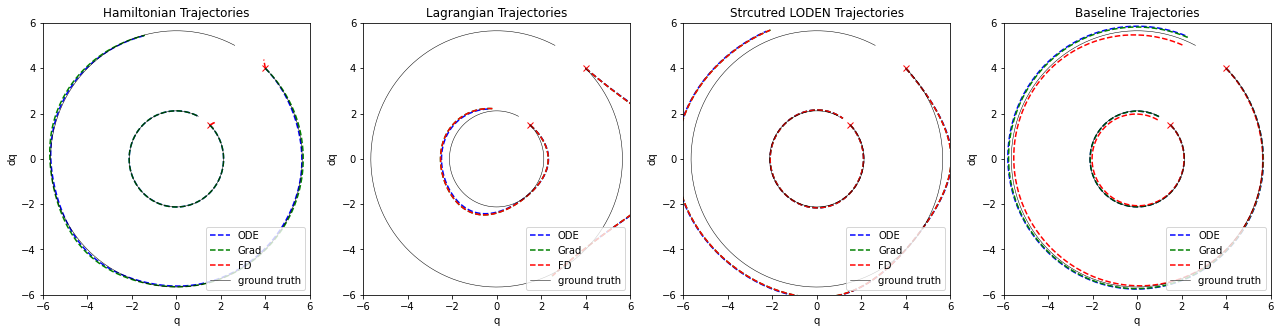

In [10]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(22, 5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

axs = [ax1, ax2, ax3, ax4]

length = 120
for idx, ax in enumerate(axs):
    ax.plot(q_p1[0, 0], q_p1[0, 1], marker='x', color="red")  # init pos
    ax.plot(q_p2[0, 0], q_p2[0, 1], marker='x', color="red")  # init pos

    ax.plot(trajs1[idx][:length, 0, 0], trajs1[idx][:length, 0, 1], 'b--', label='ODE')
    ax.plot(trajs1[idx+4][:length, 0, 0], trajs1[idx+4][:length, 0, 1], 'g--', label='Grad')
    ax.plot(trajs1[idx+8][:length, 0, 0], trajs1[idx+8][:length, 0, 1], 'r--', label='FD')
    ax.plot(q_p1[:length, 0], q_p1[:length, 1], color='black', alpha=1, label='ground truth', linewidth=0.5)

    ax.plot(trajs2[idx][:length, 0, 0], trajs2[idx][:length, 0, 1], 'b--')
    ax.plot(trajs2[idx+4][:length, 0, 0], trajs2[idx+4][:length, 0, 1], 'g--')
    ax.plot(trajs2[idx+8][:length, 0, 0], trajs2[idx+8][:length, 0, 1], 'r--')
    ax.plot(q_p2[:length, 0], q_p2[:length, 1], color='black', alpha=1, linewidth=0.5)

    ax.set_xlim([-6., 6.])
    ax.set_ylim([-6., 6.])
    ax.set_xlabel("q")
    ax.set_ylabel("dq")
    ax.legend(loc='lower right')
    
ax1.set_title("Hamiltonian Trajectories")
ax2.set_title("Lagrangian Trajectories")
ax3.set_title("Strcutred LODEN Trajectories")
ax4.set_title("Baseline Trajectories")

None

### s-t v-t

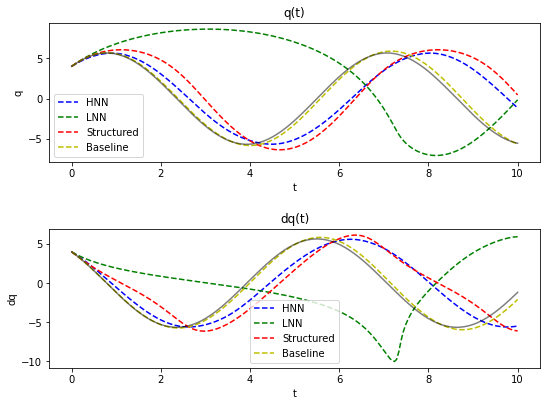

In [11]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)

ax1.plot(t_span, trajs2[0][:, 0, 0], 'b--', label='HNN')
ax1.plot(t_span, trajs2[1][:, 0, 0], 'g--', label='LNN')
ax1.plot(t_span, trajs2[2][:, 0, 0], 'r--', label='Structured')
ax1.plot(t_span, trajs2[3][:, 0, 0], 'y--', label='Baseline')

ax1.plot(t_span, q_p2[:, 0], color='black', alpha=0.5)  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span, trajs2[0][:, 0, 1], 'b--', label='HNN')
ax2.plot(t_span, trajs2[1][:, 0, 1], 'g--', label='LNN')
ax2.plot(t_span, trajs2[2][:, 0, 1], 'r--', label='Structured')
ax2.plot(t_span, trajs2[3][:, 0, 1], 'y--', label='Baseline')
ax2.plot(t_span, q_p2[:, 1], color='black', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

ax1.legend()
ax2.legend()
fig.tight_layout(pad=2.0)
None

In [15]:
test_model = models[1]

In [16]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-4.5, 4.5, n_grid)
    Q, dQ = torch.meshgrid(x, x)  # all (q, p)

    L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
            L[i, j] = test_model.defunc.m.L(x)
            grad = test_model.defunc(0, x).detach().cpu()
            U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

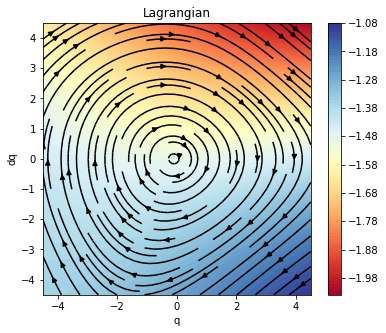

In [17]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagrangian")
None